# **HW1**
**GENRAL APPROACH:**
----------------------
***PART 1:***
**1)** I got the ip address of the virtual machine that has been assigend to me from the google cloud (to be more specific, I used the external ip address for the further steps because I could not get the location of the VM using the private IP addrress). Then I pseudo-randomly chose servers of different countries from the reference websites (https://www.debian.org/mirror/list and https://www.gnu.org/prep/ftp.html). In this way, the closest server was in US and the furthest was in Australia. I put them in a csv file, then I read it as a pandas dataframe in my notebook. afterwards their, latitude and longtitude has been obtained based on their ip addresses. for this purpose, I wrote a script to send http GET requests to [https://ipapi.co/](https://ipapi.co/) website API. Using lat. and long. , I computed the geographical distances between the source and each destination.
-------------------------------------------------------------------
**2)** At this point, I created TCP SYN packets in order for performing my ping process. I used TCP because in general even if a server is configured in such a way that is not responsive to the python built-in ping or ICM echo-request, we still could receive a response(SYN-ACK) to perform our measurement. Finally, I sent SYN messages to different destinations and computed the average Round-Trip-Time (RTT) for each destination based on their responses.
--------------------------------------------------------------------
**3)** At last, I created a dataframe contaning target ip (and target name)and their corresponding average RTT and geographical distance. After sorting in an increasing order w.r.t the distances, I ploted RTT vs. distances.
--------------------------------------------------------------------
_______________
***PART2***
As it has been guided, I used Polyfit method of numpy library, to minimize the least square error that resulted in having a linear estimation of RTTs based on their corresponding distances. In general, one can conclude that apart from distance, there are other parameters that may affect RTT(eg.network congestion, bandwith, packet loss, etc ). However, distance is the most effective parameter and we can have a fair linear estimation of RTT based on the distance.
--------------------------------------------------------------------
____________________________________________________________________

In [1]:
!pip install pythonping
!pip install --pre scapy[basic]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import urllib.request
import json
from scapy.all import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat
import pandas as pd
import numpy as np
import socket
import requests
from geopy.distance import distance
import csv

In [3]:
#getting the Private Ip address(however, we do not use it)
hostname = socket.gethostname()
my_private_ip = socket.gethostbyname(hostname)
my_private_ip

'172.28.0.12'

In [4]:
#getting the VM specifications such as External IP, that will be used in the future blocks
import urllib.request
import json

my_ip = urllib.request.urlopen('https://api.ipify.org').read().decode('UTF-8')
ip_info = json.loads(urllib.request.urlopen('http://ip-api.com/json/' + my_ip).read())

print('External IP: ', my_ip)
print('Organization: ', ip_info["org"])
print('Location: ', ip_info["city"], ',', ip_info["country"])

External IP:  35.221.13.20
Organization:  Google Cloud (us-east4)
Location:  Washington , United States


In [5]:
#reading and preprocessing the CSV file of destination server addresses
df = pd.read_csv("/content/server_adrress_hw1 (1).csv")
df["adress"] = df["adress"].str.replace('/debian/', '')
df["adress"] = df["adress"].str.replace('http://', '')
df["adress"] = df["adress"].str.replace('https://', '')
df["adress"] = df["adress"].str.replace('ftp://', '')
df["adress"] = df["adress"].str.replace('/ftp/', '')
df["adress"] = df["adress"].str.replace('ftp/', '')
df["adress"] = df["adress"].str.replace('www.', '')
df["adress"] = df["adress"].str.replace('rsync://', '')
df["adress"] = df["adress"].str.replace('/ftp/', '')
df["adress"] = df["adress"].str.replace('/GNU/', '')
df["adress"] = df["adress"].str.replace('gnu/', '')
df["adress"] = df["adress"].str.replace('/pub', '')
df["adress"] = df["adress"].str.replace('/mirrors', '')
df["adress"] = df["adress"].str.replace('/gnu', '')
df["adress"] = df["adress"].str.replace('/', '')
df["adress"]=df["adress"].apply(lambda x: f"{x}")
df = df.drop_duplicates()

df.head(10)

<ipython-input-5-f1169d54bee9>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df["adress"] = df["adress"].str.replace('www.', '')


,Country,adress
0,Australia,ftp.au.debian.org
1,Austria,ftp.at.debian.org
2,Belarus,ftp.by.debian.org
3,Belgium,ftp.be.debian.org
4,Brazil,ftp.br.debian.org
5,Bulgaria,ftp.bg.debian.org
6,China,ftp.cn.debian.org
7,Croatia,ftp.hr.debian.org
8,Czech Republic,ftp.cz.debian.org
9,Denmark,ftp.dk.debian.org


In [6]:
#saving addrresses in a list
target = df["adress"].values
target = target.tolist()
print("Target Server Names: " ,target)
print("The number of Servers: " ,len(target))

Target Server Names:  ['ftp.au.debian.org', 'ftp.at.debian.org', 'ftp.by.debian.org', 'ftp.be.debian.org', 'ftp.br.debian.org', 'ftp.bg.debian.org', 'ftp.cn.debian.org', 'ftp.hr.debian.org', 'ftp.cz.debian.org', 'ftp.dk.debian.org', 'ftp.fi.debian.org', 'ftp.fr.debian.org', 'ftp.de.debian.org', 'ftp.hk.debian.org', 'ftp.hu.debian.org', 'ftp.is.debian.org', 'ftp.it.debian.org', 'ftp.jp.debian.org', 'ftp.lt.debian.org', 'ftp.nl.debian.org', 'ftp.nc.debian.org', 'ftp.pl.debian.org', 'ftp.pt.debian.org', 'ftp.ru.debian.org', 'ftp.sk.debian.org', 'ftp.si.debian.org', 'ftp.es.debian.org', 'ftp.se.debian.org', 'ftp.ch.debian.org', 'ftp.uk.debian.org', 'ftp.us.debian.org', 'ftp.nz.debian.org', 'mirrors.gethosted.online', 'gnu.mirror.iweb.com', 'gnuftp.uib.no', 'gnualpha.uib.no', 'ftp.cc.uoc.gr', 'mirror.hostiran.ir', 'mirror.ufs.ac.za', 'mirror.marwan.ma', 'gnu.c3sl.ufpr.br', 'gnu.mirror.constant.com']
The number of Servers:  42


In [7]:
#obtaining the corresponding IP addrresses and saving it as a list
target_ip=[]
for t in target:
  target_ip.append(socket.gethostbyname(t))

print("Target IP addrresses: " ,target_ip)

Target IP addrresses:  ['103.84.224.37', '213.129.232.18', '82.209.230.71', '195.234.45.114', '200.236.31.3', '130.89.148.12', '45.125.0.6', '161.53.160.11', '78.128.211.127', '130.225.254.116', '194.71.11.173', '212.27.32.66', '141.76.2.4', '45.125.0.6', '195.228.252.133', '78.129.164.123', '85.94.199.210', '133.5.166.3', '158.129.159.169', '130.89.149.21', '103.2.186.80', '153.19.251.221', '130.89.148.12', '85.143.112.112', '195.80.174.186', '213.129.232.18', '130.89.148.12', '194.71.11.173', '129.132.53.171', '78.129.164.123', '64.50.236.52', '163.7.134.112', '194.156.79.82', '192.175.120.174', '129.177.13.60', '129.177.13.60', '147.52.159.12', '185.173.106.68', '196.255.240.40', '196.200.160.70', '200.236.31.1', '108.61.5.83']


In [8]:
#latitude and longtitude of source 
my_response = requests.get(f'https://ipapi.co/{my_ip}/latlong/') # Making a GET request to the ipapi API
my_lat_lang = my_response.text.split(',') # Extracting the latitude and longitude from the response

#latitude and longtitude of destinations
response=[]
lat_lang=[]
for i in range(len(target_ip)):
  response.append(requests.get(f'https://ipapi.co/{target_ip[i]}/latlong/')) # Make a GET request to the ipapi API
  lat_lang.append(response[i].text.split(',')) # Extract the latitude and longitude from the response

print("Target latitude and langtitude List: ", lat_lang)
print("Source Latitude and langtitude: ", my_lat_lang)

Target latitude and langtitude List:  [['-33.871500', '151.200600'], ['48.204900', '16.366200'], ['53.900700', '27.570900'], ['50.819500', '5.186300'], ['-25.502600', '-49.290800'], ['52.238500', '6.870600'], ['22.290800', '114.150100'], ['45.829300', '15.979300'], ['50.088300', '14.412400'], ['55.680200', '12.589200'], ['63.824700', '20.255900'], ['49.442900', '1.100300'], ['50.949900', '13.344000'], ['22.290800', '114.150100'], ['47.563600', '19.094700'], ['51.518000', '-0.086900'], ['45.547000', '9.124100'], ['33.618400', '130.410900'], ['54.747600', '25.502500'], ['52.238500', '6.870600'], ['-22.266500', '166.474200'], ['54.353000', '18.659000'], ['52.238500', '6.870600'], ['55.748300', '37.617100'], ['48.463600', '19.187300'], ['48.204900', '16.366200'], ['52.238500', '6.870600'], ['63.824700', '20.255900'], ['47.398900', '8.496500'], ['51.518000', '-0.086900'], ['41.848600', '-87.628800'], ['-41.273400', '173.302400'], ['52.414100', '-0.521600'], ['45.527800', '-73.668400'], ['58

**NOTE:** During the experiment, **sometimes** I faced a problem with getting lat. and long. from the aforementioned API (previous cell). because their server identified my activity as a "suspicious" one and gave me an error message. So that, I handeled this problem with the below code cell. Basically, I wrote lat. and long. in a csv file and then it is used only if the error response is obtained in the previous cell.
when there is an error for any of targets, using the information of the backup csv for them is fine. For source (since it can be changed based on different VM in colab) I used the most frequent source position that I was getting -which was in the US- only when source ip address is in the US. Unless I asked to run the previous cell again. I emphasize, it is a rare situation and can be solved by trying to run the previouse cell multiple times or with a different ip.

In [9]:
# if we could not get latitude and longtitude from the above cell(due to an error response), we handel it by reading back_up_lat_long.csv
'''The Error message:
["{'error': True", " 'reason': 'RateLimited'", " 'message': 'Visit https://ipapi.co/ratelimited/ for details'}"]'''

with open('/content/back_up_lat_long .csv', 'r') as file:
      reader = csv.reader(file)
      temp = [] #a list to store lat and long in the following format ['lat','long']
      for row in reader:
        list_data = [row[0], row[1]] #to create ['lat','long'] format for each target
        temp.append(list_data)

#considering all targets
for i in range(len(target)): 
  if lat_lang[i][0] == '{\'error\': True': 
    print('Reading from back up CSV...') 
    lat_lang = temp[1:-1] #eliminating first and last row (first: title, last: lat. and long. of the source )
    print("(from backup CSV) Target latitude and langtitude List: ", lat_lang)
    break

#considering the source
if my_lat_lang[0] == '{\'error\': True':
  if ip_info["country"] == "United States":
    my_lat_lang = temp[-1] #last row is the lat. and long. of the source
    print("(from backup CSV) Source Latitude and langtitude: ", my_lat_lang)
  else:
    print("Run the previous cell again")

In [10]:
#computing the geographical distances between the source and destinations
src_target_distance=[]
for j in range(len(lat_lang)):
  src_target_distance.append(distance(my_lat_lang, lat_lang[j]).km)
print("Source-Target destinations: ", src_target_distance)

Source-Target destinations:  [15710.34380957452, 7142.501962242903, 7463.342212322146, 6288.890058473905, 7691.947878863373, 6336.939364828743, 13132.236622094224, 7251.841076465838, 6915.735712495751, 6529.99236103618, 6541.220245432959, 6072.980161316777, 6804.054299613933, 13132.236622094224, 7353.983684506237, 5916.190348777699, 6801.151345714117, 11493.580936404493, 7299.0541499489555, 6336.939364828743, 13787.626413892429, 6943.119609218711, 6336.939364828743, 7843.636169762181, 7306.861638536903, 7142.501962242903, 6336.939364828743, 6541.220245432959, 6665.331591775603, 5916.190348777699, 956.7550510772513, 14185.957631803516, 5856.897092476348, 787.4104804127307, 6018.000777418753, 6018.000777418753, 8273.600163093735, 10199.498313930137, 13052.35634001195, 6119.648095179581, 7691.947878863373, 285.79131195590713]


In [11]:
#sending SYN messages from the source to each destination and computing average RTT
num_req = 10
RTT = np.zeros((len(target),num_req))
replied = 0
#lost = 0
for t in range(len(target_ip)):
  for n in range(num_req):
    #packet = IP(dst = target_ip[t]) / ICMP(type = 'echo-request',seq=n)
    packet = IP(dst = target_ip[t]) / TCP(dport = 80, flags = 'S',seq=n) 
    ans, unans = sr(packet, verbose = False, timeout = 5)
    if(len(ans)>0):
      query = ans[0][0] 
      answer = ans[0][1]
      RTT[t][n] = (answer.time - query.sent_time)*1000 #each row represent the destination, each Col represents RTT
      #replied = replied+1
    #if(len(unans)>0):
      #lost+=len(unans)
avg_rtt = np.sum(RTT, axis=1)/np.shape(RTT)[1] # averaging over Cols for each row (avg RTT between src and each destination)

#avg_rtt

In [12]:
np.where(avg_rtt == 0) #finding the indexes with zero value(if any)

(array([ 2, 37]),)

In [13]:
#removing servers that did not respond to SYN (if any) 
no_response_index = np.where(avg_rtt == 0)[0]
for nri in no_response_index:
  del target[nri]
  del target_ip[nri]
  del src_target_distance[nri]
avg_rtt = np.delete(avg_rtt, no_response_index)

In [14]:
print("AVG RTTs List: " + ' , '.join(map(str, avg_rtt)))

AVG RTTs List: 197.07129001617432 , 109.2536211013794 , 91.4027452468872 , 119.91140842437744 , 88.19687366485596 , 186.521315574646 , 124.15010929107666 , 92.85426139831543 , 107.96201229095459 , 108.90905857086182 , 79.68058586120605 , 100.73044300079346 , 186.48076057434082 , 103.60064506530762 , 85.45413017272949 , 103.55088710784912 , 165.3728485107422 , 112.23535537719727 , 88.11953067779541 , 236.2072229385376 , 107.04953670501709 , 87.98182010650635 , 112.8929853439331 , 99.94423389434814 , 109.14947986602783 , 88.03961277008057 , 108.94320011138916 , 92.49486923217773 , 86.4163875579834 , 20.505833625793457 , 207.867431640625 , 85.74106693267822 , 15.46783447265625 , 106.07857704162598 , 105.89795112609863 , 130.83324432373047 , 241.3325548171997 , 114.0028715133667 , 119.89278793334961 , 7.14569091796875


Note: servers with same IP addresses (like the example, below)are redundant information that has been removed in the following code block

In [15]:
socket.gethostbyname('ftp.uk.debian.org') == socket.gethostbyname('ftp.is.debian.org')

True

In [16]:
#Creating the result dataframe
result = {'target_name': target , 'target_ip': target_ip , 'avg_rtt': avg_rtt, 'src_target_distance': src_target_distance}
result_df = pd.DataFrame(result)
sorted_result_df = result_df.sort_values(by = 'src_target_distance') #sorting
del result_df
sorted_unique_result_df = sorted_result_df.drop_duplicates(subset=['target_ip']) #removing redundant rows
del sorted_result_df
sorted_unique_result_df.head(10)

,target_name,target_ip,avg_rtt,src_target_distance
39,gnu.mirror.constant.com,108.61.5.83,7.145691,285.791312
32,gnu.mirror.iweb.com,192.175.120.174,15.467834,787.410480
29,ftp.us.debian.org,64.50.236.52,20.505834,956.755051
31,mirrors.gethosted.online,194.156.79.82,85.741067,5856.897092
28,ftp.uk.debian.org,78.129.164.123,86.416388,5916.190349
34,gnualpha.uib.no,129.177.13.60,105.897951,6018.000777
10,ftp.fr.debian.org,212.27.32.66,79.680586,6072.980161
37,mirror.marwan.ma,196.200.160.70,114.002872,6119.648095
2,ftp.be.debian.org,195.234.45.114,91.402745,6288.890058
25,ftp.es.debian.org,130.89.148.12,88.039613,6336.939365


In [17]:
print("The final number of Servers: " ,len(target)) #after removing duplicated IP adrresses

The final number of Servers:  40


The Following graphs shows that RTT generally has a linear relation with distance. However, it can be seen there are some spikes in the graph meaning that there are some further serveres with smaller RTT. we can conclude that distance is not the only effective parameter (e.g eg.network congestion, bandwith, packet loss, etc). For example the maximum average RTT belongs to **"IRAN"** that its government reduces the bandwidth of the whole country, due to the political issues. But apart from that, one can says distance is the most effective factor. Therefore, a fair estimation of RTT can be obtained based on the geographical distance.

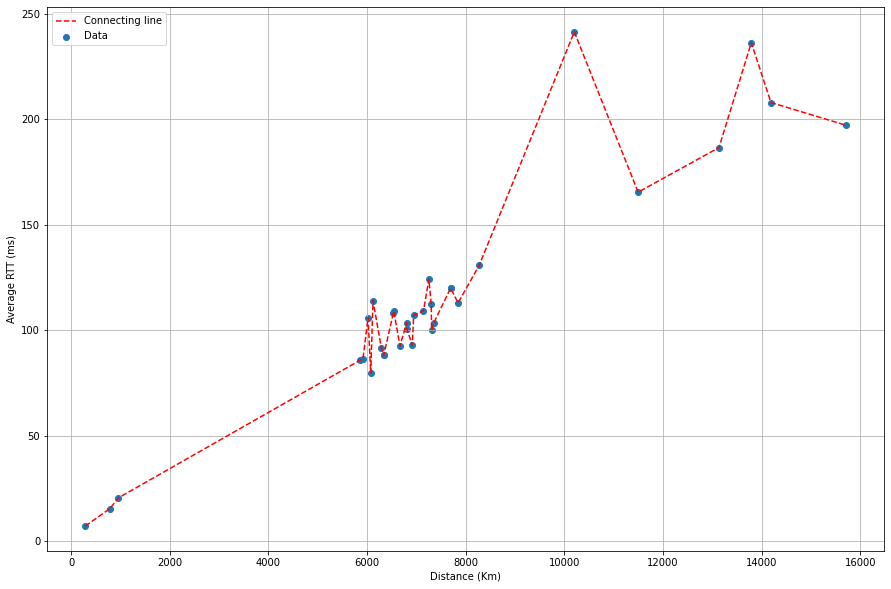

In [18]:
fig = plt.figure(figsize =(15,10));
plt.plot(sorted_unique_result_df['src_target_distance'],sorted_unique_result_df['avg_rtt'], "r--");
plt.scatter(sorted_unique_result_df['src_target_distance'],sorted_unique_result_df['avg_rtt']);

plt.xlabel("Distance (Km)");
plt.ylabel("Average RTT (ms)");
plt.grid(visible=True);
plt.legend(["Connecting line", "Data"],loc ="upper left");

Linear function: RTT = 0.01 * distance + 5.64
Average RTT per km: 0.014562 ms/km


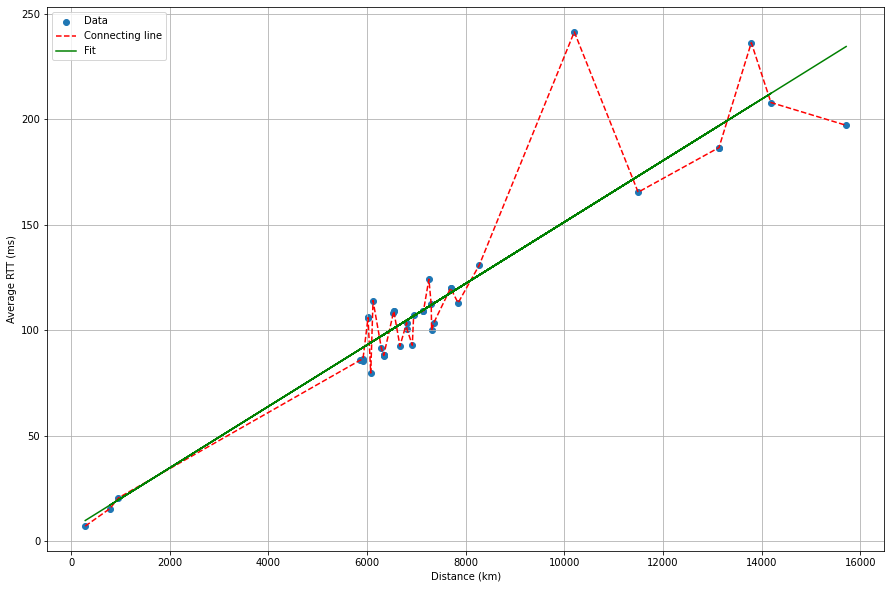

In [19]:
distances = np.array(src_target_distance)  # km
rtts = np.array(avg_rtt)  # ms

# Fit a linear function to the data
coeffs = np.polyfit(distances, rtts, deg=1)
slope, intercept = coeffs

# Estimate the average RTT per km
avg_rtt_per_km = slope  

# Print the results
print(f"Linear function: RTT = {slope:.2f} * distance + {intercept:.2f}")
print(f"Average RTT per km: {avg_rtt_per_km:.6f} ms/km")

# Plot the results
fig = plt.figure(figsize =(15,10));
plt.scatter(distances, rtts)
plt.plot(sorted_unique_result_df['src_target_distance'],sorted_unique_result_df['avg_rtt'], 'r--');
plt.plot(distances, slope * distances + intercept, color='green')
plt.xlabel("Distance (km)");
plt.ylabel("Average RTT (ms)");
plt.grid(visible=True);
plt.legend(["Data", "Connecting line", "Fit"], loc ="upper left");
plt.show()